In [3]:
import numpy as np

def least_square(regressor, response):
    # use numpy.linalg.lstsq
    # modify residual and singular value, eliminate the effect caused by data size
    if regressor.shape[0] <= regressor.shape[1]:
        raise ValueError("regressor size error, #datums <= #variables")
    
    coe, res, rank, singular_value = np.linalg.lstsq(regressor, response, rcond=-1)
    rms = res / (regressor.shape[0] - regressor.shape[1]) # residual mean square
    return coe, rms, rank, singular_value

def pcvar(data):
    # data : numpy matrix
    # return Variance of each principal component
    if data.shape[0] < 2:
        raise ValueError("data size error, variance of single datum is meaningless")
    
    data -= data.mean(axis=0)
    output = np.linalg.eigvalsh(np.dot(data.T, data))[::-1]/(data.shape[0] - 1)
    return output

class LinearRegression():
    def __init__(self, regressor, response, has_bias = True, regularizer = 10**-6):
        self.set_data(regressor, response, has_bias)
        self.set_regularizer(regularizer)
    
    def set_data(self, regressor, response, has_bias):
        if (regressor.ndim != 2) or (regressor.size == 0):
            raise ValueError("regressor should be a non-empty numpy matrix")
        elif (response.ndim != 2) or (response.size == 0):
            raise ValueError("response should be a non-empty numpy matrix")
        elif len(regressor) != len(response):
            raise ValueError("len(regressor) != len(response)")
        
        self.num_var = regressor.shape[1]
        self.has_bias = has_bias
        if self.has_bias:
            self.regressor = np.append(regressor, np.ones((len(regressor), 1)), axis=1)
        else:
            self.regressor = regressor
        
        self.response = response
    
    def set_regularizer(self, regularizer):
        if regularizer < 0.:
            self.regularizer = 0.
            print("set_regularizer error, regularizer must be non-negative, has been set to zero.")
        else:
            self.regularizer = regularizer
    
    def most_useless_analysis(self, drop=1):
        gram = np.dot(self.regressor.T, self.regressor)
        gram += self.regularizer * self.regressor.shape[0] * np.identity(self.regressor.shape[1])
        projected = np.dot(self.regressor.T, self.response)
        is_leave = np.ones((gram.shape[0]), dtype=bool)
        response_square = np.square(self.response).sum(axis=0)
        for d in range(drop):
            square_err = np.inf * np.ones((gram.shape[0]), dtype=bool)
            for i in range(self.num_var):
                if is_leave[i]:
                    work_index = (is_leave * (np.arange(len(is_leave)) != i)).astype(bool)
                    coe = np.linalg.solve(gram[work_index][:, work_index], projected[work_index])
                    square_err[i] = (response_square
                                     - (coe * projected[work_index]).sum(axis=0) 
                                     - self.regularizer * np.square(coe).sum(axis=0)
                                    ).sum()
            
            is_leave[np.argmin(square_err)] = False
        
        rms = square_err.min()/(self.regressor.shape[0] - is_leave.sum())
        coe = np.linalg.solve(gram[is_leave][:, is_leave], projected[is_leave])
        if self.has_bias:
            return is_leave[:-1], coe[:-1], coe[-1].reshape(1, -1), rms
        else:
            return is_leave, coe, np.zeros((1, self.num_var)), rms
    
    def quick_drop_useless_one(self):
        # Use PCA to find 1 useless variable
        # It can't guarantee that finding the most useless 1
        if self.has_bias:
            linear_trans, _, _, _ = np.linalg.lstsq(self.regressor, self.response, rcond=-1)
            centralized_data = self.regressor[:, :-1] - self.regressor[:, :-1].mean(axis=0)
            cori, conp = np.linalg.eigh(np.dot(centralized_data.T, centralized_data))
            cori /= self.regressor.shape[0] - self.regressor.shape[1]
            error_bound = 1/(np.square(conp) + 0.000000001)
            error_bound *= cori
            error_bound = error_bound.min(axis=1)
            error_bound *= np.linalg.norm(linear_trans[:-1], axis=1)**2
            drop = error_bound.argmin()
            
            is_leave = (np.arange(self.regressor.shape[1]) != drop)
            
            gram = np.dot(self.regressor.T, self.regressor)
            gram += self.regularizer * self.regressor.shape[0] * np.identity(self.regressor.shape[1])
            projected = np.dot(self.regressor.T, self.response)
            response_square = np.square(self.response).sum(axis=0)
            
            coe = np.linalg.solve(gram[is_leave][:, is_leave], projected[is_leave])
            square_err = (response_square
                             - (coe * projected[is_leave]).sum(axis=0) 
                             - self.regularizer * np.square(coe).sum(axis=0)
                            ).sum()
            
            rms = square_err/(self.regressor.shape[0] - is_leave.sum())
            return is_leave[:-1], coe[:-1], coe[-1].reshape(1, -1), rms
        
        else:
            raise ValueError("Quick drop only work for case with bias")

In [4]:
data = np.random.normal(0, 1, (1000000,4))
prin = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0.8, 0.6, 0, 0], [0.6, -0.8, 0, 0]])
data = np.dot(data, np.diag([2, 1.1, 1., 1.5]))
data = np.dot(data, prin)

In [5]:
np.linalg.eigh(np.dot(data.T, data)/1000000)

(array([1.0016494 , 1.20928421, 2.2561086 , 4.00593953]),
 array([[ 7.98864243e-01,  1.05697489e-03, -6.01508457e-01,
         -1.54313906e-03],
        [ 6.01505663e-01,  2.88082748e-03,  7.98862325e-01,
          1.27446690e-03],
        [-4.66056718e-04, -3.82241702e-05,  1.94640575e-03,
         -9.99997996e-01],
        [-2.57724344e-03,  9.99995291e-01, -1.66553864e-03,
         -4.02647432e-05]]))

In [6]:
myLR = LinearRegression(data, data + np.array([1,2,3,4]))

myLR.most_useless_analysis(2)

(array([False,  True,  True, False]),
 array([[-3.34473394e-01,  9.99999447e-01,  1.95554557e-09,
         -5.94729810e-04],
        [ 6.33484295e-04, -6.73787209e-10,  9.99999750e-01,
          2.70446056e-05]]),
 array([[0.99833356, 1.999998  , 2.999997  , 4.00059338]]),
 2.4632334031640264)

In [7]:
myLR.quick_drop_useless_one()

(array([ True,  True,  True, False]),
 array([[ 9.99999201e-01, -2.69400676e-07, -3.47938420e-09,
          8.92468671e-04],
        [-2.66450012e-07,  9.99999357e-01,  7.91784128e-10,
         -2.96222784e-04],
        [ 2.99162715e-10, -5.03126056e-10,  9.99999750e-01,
          2.64792406e-05]]),
 array([[0.999999  , 1.999998  , 2.999997  , 4.00059487]]),
 1.209321589418169)

# pytorch version

In [8]:
import numpy as np
import torch
from torch.autograd import Variable

torch.set_default_tensor_type(torch.FloatTensor)

In [9]:
def np2torch(numpy_array, torch_type = None):
    if torch_type is None:
        torch_type = torch.get_default_dtype()
    return torch.from_numpy(numpy_array).type(torch_type)

def to_32(x):
    return x.type(torch.FloatTensor)

def to_64(x):
    return x.type(torch.DoubleTensor)

def two_square_trace(A, B):
    # find tr(AB)
    # see https://github.com/Dogiko/Some-Tools
    return A.view(1,-1).mm(B.t().contiguous().view(-1,1)).view(())

def pos_gram(gram, regularlizer = None):
    _type = gram.type()
    _size = len(gram)
    if regularlizer is None:
        if gram.abs().max() == 0:
            raise ValueError("gram error, expect matrix with none-zero element")
        
        # the fraction of float32 is 2**(-23)~10**(-7) we start with 10**(-7) times of maximun element
        regularlizer = gram.abs().max()*0.0000001
    
    if regularlizer <= 0:
        raise ValueError("regularlizer error, expect positive, got %s" %(regularlizer))
    
    while True:
        lambdas, vectors = torch.symeig(gram + regularlizer*torch.eye(_size).type(_type))
        if lambdas.min() > 0:
            break
        
        regularlizer *= 2.
    
    return gram + regularlizer*torch.eye(_size).type(_type)

class LinearRefiner():
    def __init__(self, linearModel, regularizer = None):
        self.set_model(linearModel)
        self.set_regularizer(regularizer)
    
    def set_model(self, linearModel):
        if type(linearModel) != torch.nn.Linear:
            raise TypeError("linearModel type error, got, expect torch.nn.Linear")
        
        self.model_weight = linearModel.weight.data
        self.model_bias = linearModel.bias.data
        self.in_features = linearModel.in_features
        self.reset()
    
    def set_regularizer(self, regularizer):
        self.regularizer = regularizer
    
    def reset(self):
        self.datums_acc = 0
        self.gram = torch.zeros((self.in_features+1, self.in_features+1))
    
    def data_input(self, data):
        datums = data.size()[0]
        expand = torch.cat((data, torch.ones((datums, 1))), 1)
        self.gram += torch.mm(expand.t(), expand)
        self.datums_acc += datums
    
    def drop_error(self, estimate = False):
        # return errors of drop each regressor
        # if estimate = True, using PCA get upper-bound of errors
        expand_model = to_64(torch.cat((self.model_weight, self.model_bias.view(-1,1)), 1).t())
        mean_gram = pos_gram(to_64(self.gram / self.datums_acc), self.regularizer) # avoid singular gram
        res_ms = two_square_trace(expand_model.mm(expand_model.t()), mean_gram) # mean of square sum of y = xA
        if estimate:
            unbiased_gram = pos_gram(mean_gram[:-1, :-1] - torch.mm(mean_gram[:-1, -1:], mean_gram[-1:, :-1]))
            cori, comp = torch.symeig(unbiased_gram, eigenvectors=True) # PCA
            error_bound = 1/(0.0000001 + comp**2) # 0.0000001 for stability, avoid divide zero
            error_bound *= cori
            error_bound = error_bound.min(1)[0]*((expand_model[:-1]**2).sum(1)) # square-norm for weight without bias
            
            error_bound = to_32(error_bound)
            res_ms = to_32(res_ms)
            return error_bound, res_ms
        else:
            errors = to_64(torch.zeros((len(mean_gram)-1)))
            _idx = list(range(self.in_features + 1))
            for p in range(len(mean_gram)-1):
                drop_p_idx = _idx[:p] + _idx[p+1:]
                subgram = mean_gram[drop_p_idx][:, drop_p_idx]
                new_model = torch.gesv(mean_gram[drop_p_idx, : ].mm(expand_model), subgram)[0]
                errors[p] = res_ms - two_square_trace(new_model.mm(new_model.t()), subgram)
            
            errors = to_32(errors)
            res_ms = to_32(res_ms)
            return errors, res_ms
    
    def refine(self, drop = 1, quick = True):
        if self.datums_acc == 0:
            raise ValueError(".datums_acc == 0, must input data before refine.")
        
        leave_idx = list(range(self.in_features + 1)) # +1 for bias
        expand_model = to_64(torch.cat((self.model_weight, self.model_bias.view(-1,1)), 1).t())
        mean_gram = pos_gram(to_64(self.gram / self.datums_acc), self.regularizer)
        # avoid singular gram
        res_ms = two_square_trace(expand_model.mm(expand_model.t()), mean_gram) # mean of square sum of y = xA
        if quick:
            new_model = expand_model.clone()
            for d in range(drop):
                subgram = mean_gram[leave_idx][:, leave_idx]
                unbiased_subgram = pos_gram(subgram[:-1, :-1] - torch.mm(subgram[:-1, -1:], subgram[-1:, :-1]))
                cori, comp = torch.symeig(unbiased_subgram, eigenvectors=True) # PCA
                error_bound = 1/(0.000000000000001 + comp**2) # 0.000000000000001 for stability, avoid divide zero
                error_bound *= cori
                error_bound = error_bound.min(1)[0]*((new_model[:-1]**2).sum(1)) # square-norm for weight without bias
                pos = error_bound.min(0)[1] # argmin for bound, position for variable should be remove in leave index
                leave_pos = list(range(len(leave_idx))) # leave_idx for leave_idx
                leave_pos.remove(pos)
                drop_p_gram = subgram[leave_pos][:, leave_pos]
                # ridge regrassion : linear regression with regularlizer, guaranty existence of only one minimun
                new_model = torch.gesv(subgram[leave_pos, : ].mm(new_model), drop_p_gram)[0]
                leave_idx = leave_idx[:pos] + leave_idx[pos+1:] # update leave_idx
            
            mse = res_ms - two_square_trace(new_model.mm(new_model.t()), mean_gram[leave_idx][:, leave_idx])
        else:
            for d in range(drop):
                leave_err = torch.zeros((len(leave_idx)-1))
                for p in range(len(leave_idx)-1):
                    drop_p_idx = leave_idx[:p] + leave_idx[p+1:]
                    drop_p_gram = mean_gram[drop_p_idx][:, drop_p_idx]
                    new_model = torch.gesv(mean_gram[drop_p_idx, : ].mm(expand_model), drop_p_gram)[0]
                    leave_err[p] = res_ms - two_square_trace(new_model.mm(new_model.t()), drop_p_gram)
                
                mse, pos = leave_err.min(0)
                leave_idx = leave_idx[:pos] + leave_idx[pos+1:]
            
            subgram = mean_gram[leave_idx][:, leave_idx]
            new_model = torch.gesv(mean_gram[leave_idx, : ].mm(expand_model), subgram)[0]
        
        # mean square error
        
        new_model = to_32(new_model)
        mse = to_32(mse)
        res_ms = to_32(res_ms)
        return leave_idx[:-1], new_model[:-1].t(), new_model[-1].view((-1)), mse, res_ms

In [10]:
data = np2torch(np.random.normal(0, 1, (1000000, 4)))
prin = np2torch(np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0.8, 0.6, 0, 0], [0.6, -0.8, 0, 0]]))
data = data.mm(torch.diag(torch.Tensor([2., 1.1, 1., 1.5]))).mm(prin)
linear = torch.nn.modules.Linear(4, 4, bias=True)
linear.weight.data = torch.eye(4)
linear.bias.data = torch.Tensor([1, 2, 3, 4])
my_linear_refiner = LinearRefiner(linear)
my_linear_refiner.data_input(data)

my_linear_refiner.refine(1)

([0, 1, 2], tensor([[ 1.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  1.0000],
         [-0.0005, -0.0004, -0.0000]]), tensor([1.0000, 2.0000, 3.0000, 4.0000]), tensor(1.2077), tensor(38.4530))

In [11]:
print(my_linear_refiner.drop_error())
print(my_linear_refiner.drop_error(estimate=True))
print(my_linear_refiner.refine(1)[3]/(linear(data).data**2).mean(0).sum())

(tensor([1.2482, 1.5515, 3.9893, 1.2077]), tensor(38.4530))
(tensor([1.5591, 2.7817, 3.9893, 1.2077]), tensor(38.4530))
tensor(0.0314)


In [12]:
my_linear_refiner.refine(2)

([1, 2], tensor([[-0.3330,  0.0009],
         [ 1.0000,  0.0000],
         [ 0.0000,  1.0000],
         [-0.0002, -0.0000]]), tensor([1.0009, 2.0000, 3.0000, 4.0000]), tensor(2.4559), tensor(38.4530))

In [13]:
my_linear_refiner.refine(1, quick=False)

([0, 1, 2], tensor([[ 1.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  1.0000],
         [-0.0005, -0.0004, -0.0000]]), tensor([1.0000, 2.0000, 3.0000, 4.0000]), tensor(1.2077), tensor(38.4530))

In [15]:
my_linear_refiner.reset()
my_linear_refiner.data_input(data[:1000])
my_linear_refiner.data_input(data[1000:])

my_linear_refiner.refine(1)

([0, 1, 2], tensor([[ 1.0000e+00,  4.1369e-17, -1.0871e-19],
         [-7.6685e-17,  1.0000e+00, -2.1742e-19],
         [-5.7854e-20, -1.3976e-19,  1.0000e+00],
         [-5.2154e-04, -3.6115e-04, -3.1210e-05]]), tensor([1.0000, 2.0000, 3.0000, 4.0000]), tensor(1.2077), tensor(38.4530))

# Compare

In [16]:
x = np.random.normal(0, 1, (10000,5))
b = np.random.normal(0, 1, (2))
A = np.random.normal(0, 1, (2,5))
y = np.dot(x, A.T) + b

In [17]:
myLR = LinearRegression(x, y)

myLR.quick_drop_useless_one()

(array([ True,  True,  True,  True, False]), array([[-0.47370461,  1.0729814 ],
        [ 0.63462901, -0.30281068],
        [-1.15664563,  0.55470661],
        [ 0.56363912,  0.4343164 ]]), array([[ 0.40931801, -0.46809887]]), 0.03877764965096857)

In [18]:
myLR.most_useless_analysis(2)

(array([ True, False,  True,  True, False]), array([[-0.47752537,  1.07480446],
        [-1.16679318,  0.55954847],
        [ 0.56126137,  0.43545093]]), array([[ 0.41305917, -0.46988396]]), 0.5363484826459067)

In [19]:
linear = torch.nn.modules.Linear(5,2,bias=True)
linear.weight.data = np2torch(A)
linear.bias.data = np2torch(b)
my_linear_refiner = LinearRefiner(linear)
my_linear_refiner.data_input(np2torch(x))

my_linear_refiner.refine(1)

([0, 1, 2, 3], tensor([[-0.4737,  0.6346, -1.1566,  0.5636],
         [ 1.0730, -0.3028,  0.5547,  0.4343]]), tensor([ 0.4093, -0.4681]), tensor(0.0388), tensor(4.5471))

In [20]:
my_linear_refiner.refine(2)

([0, 1, 2], tensor([[-0.4772,  0.6325, -1.1547],
         [ 1.0703, -0.3045,  0.5562]]), tensor([ 0.4108, -0.4669]), tensor(0.5540), tensor(4.5471))

In [21]:
my_linear_refiner.refine(2, quick=False)

([0, 2, 3], tensor([[-0.4775, -1.1668,  0.5613],
         [ 1.0748,  0.5595,  0.4355]]), tensor([ 0.4131, -0.4699]), tensor(0.5361), tensor(4.5471))

# Differen between PCA and Linear Regrassion

In [19]:
foo = np.zeros((10,2))
foo[:8] = np.dot(0.5*(np.arange(8) - 3.5).reshape(8,1), np.array([[0.8, 0.6]]))
foo[8:] = np.dot((np.arange(2) - 0.5).reshape(2,1), np.array([[-0.6, 0.8]]))

In [20]:
import matplotlib.pyplot as plt

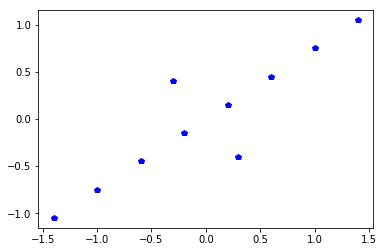

In [21]:
plt.plot(foo[:,0], foo[:,1], "bp")
plt.show()

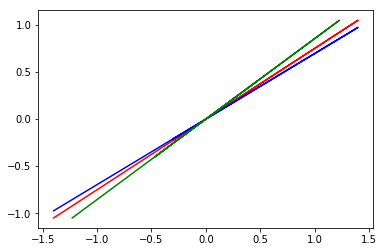

In [22]:
x2y = np.linalg.lstsq(foo[:,:1], foo[:,1:], -1)[0][0,0]
y2x = np.linalg.lstsq(foo[:,1:], foo[:,:1], -1)[0][0,0]

plt.plot(foo[:,0], foo[:,0]*0.75, "r")
plt.plot(foo[:,0], foo[:,0]*x2y, "b")
plt.plot(foo[:,1]*y2x, foo[:,1], "g")
plt.show()

In [23]:
foo = torch.Tensor([2,3])
fooo = foo.clone()
fooo[1] = 10
foo

tensor([2., 3.])

In [27]:
torch.eye(3).type(torch.eye(2).type(torch.DoubleTensor).type())

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=torch.float64)